In [1]:
import random, gc, os, pickle, csv
import matplotlib.pyplot as plt
import numpy as np

# Original ReplayMemory

In [2]:
class ReplayMemory:

    def __init__(self, write_prob, tuple_size):
        self.buffer = []
        self.write_prob = write_prob
        self.tuple_size = tuple_size

    def write(self, input_tuple):
        if random.random() < self.write_prob:
            self.buffer.append(input_tuple)

    def read(self):
        return random.choice(self.buffer)

    def write_batch(self, *elements):
        element_list = []
        for e in elements:
            if isinstance(e, torch.Tensor):
                element_list.append(e.tolist())
            else:
                element_list.append(e)
        for write_tuple in zip(*element_list):
            self.write(write_tuple)

    def read_batch(self, batch_size):
        contents = [[] for _ in range(self.tuple_size)]
        for _ in range(batch_size):
            read_tuple = self.read()
            for i in range(len(read_tuple)):
                contents[i].append(read_tuple[i])
        return tuple(contents)

    def len(self):
        return len(self.buffer)

    def reset_memory(self):
        self.buffer = []

In [3]:
def getColorFromIndex(n):
    colorList = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', \
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    return colorList[n%len(colorList)]

In [4]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


In [5]:
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"

with open(memory_path, 'rb') as f:
    memory = pickle.load(f)
len(memory.buffer)

575000

In [6]:
count_bins = {}
for example_text, example_id in memory.buffer:
    count_bins[example_id] = count_bins.get(example_id, 0) + 1
count_bins

{3: 46151,
 2: 46452,
 0: 45859,
 4: 45482,
 1: 46056,
 8: 28815,
 6: 28773,
 5: 28726,
 7: 28686,
 18: 8301,
 19: 8403,
 14: 8184,
 10: 8311,
 16: 8054,
 12: 8102,
 20: 8157,
 11: 8194,
 21: 8150,
 17: 8305,
 15: 8189,
 9: 8151,
 22: 8135,
 13: 8364,
 25: 11890,
 28: 9983,
 31: 13435,
 32: 12455,
 23: 13054,
 24: 10401,
 30: 12198,
 26: 10344,
 27: 11624,
 29: 9616}

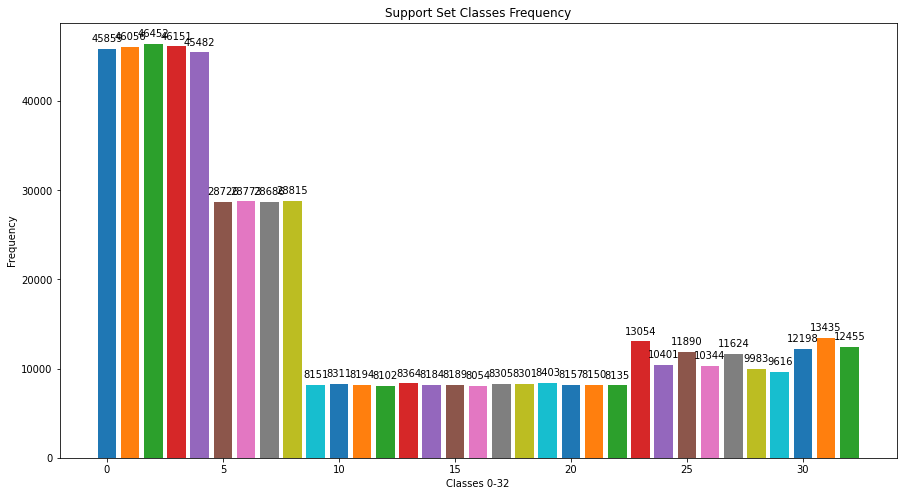

In [7]:
fig, ax =  plt.subplots(figsize=(15,8))
ax.bar(np.arange(33), [count_bins[label_id] for label_id in range(33)], color=[getColorFromIndex(i) for i in range(33)])
# ax.xaxis.set_ticklabels(np.arange(33))

ax.set_title('Support Set Classes Frequency')
ax.set_xlabel('Classes 0-32')
ax.set_ylabel('Frequency')
add_value_labels(ax)

In [8]:
random.choice([1,2,3])

1

# Label-aware ReplayMemory

In [9]:
class LabelAwareReplayMemory:

    def __init__(self, write_prob, tuple_size, n_classes=33):
        self.buffer_dict = {}
        self.n_classes = n_classes
        self.write_prob = write_prob
        self.tuple_size = tuple_size
        self.read_index = 0

    def read(self, class_id):
        return [random.choice(self.buffer_dict[class_id]), class_id]

    def read_batch(self, batch_size):
        contents = [[] for _ in range(self.tuple_size)]
        for _ in range(batch_size):
            read_tuple = self.read(self.read_index)
            self.read_index = (self.read_index + 1)%self.n_classes
            for i in range(len(read_tuple)):
                contents[i].append(read_tuple[i])
        return tuple(contents)

    def reset_memory(self):
        self.buffer_dict = {}

In [10]:
def convert_to_label_aware(buffer):
    buffer_dict = {}
    for example_text, example_id in buffer:
        buffer_dict[example_id] = buffer_dict.get(example_id, [])
        buffer_dict[example_id].append(example_text)
    return buffer_dict

In [11]:
buffer_dict = convert_to_label_aware(memory.buffer)
new_replay = LabelAwareReplayMemory(1, 2, 33)
new_replay.buffer_dict = buffer_dict

In [12]:
new_memory_path, ext = os.path.splitext(memory_path)
new_memory_path = new_memory_path + "_label" + ext

pickle.dump(new_replay, open( new_memory_path, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
new_replay.read_batch(20)[1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]